In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

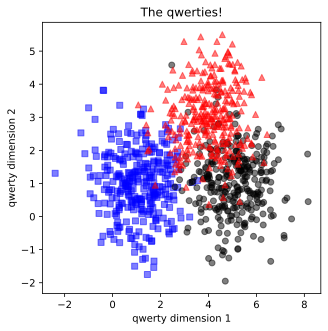

In [2]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [3]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Model

In [8]:
# create a class for the model
def createTheQwertyNet(momentum):

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            ##input layer
            self.input = nn.Linear(2,8)

            # hidden layer
            self.fc1 = nn.Linear(8,8)

            # output layer
            self.output = nn.Linear(8,3)

            # forward  pass

        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)


    # create the model instance
    net = qwertyNet()

        #loss function
    
    lossfun = nn.CrossEntropyLoss()

        # optimizer
    optimizer = torch.optim.SGD(net.parameters(),lr=.01,momentum=momentum)

    return net,lossfun,optimizer



In [9]:
# confirm that the optimizer has momentum
optim = createTheQwertyNet(.9)[2]
optim

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [10]:
# a function that trains the model


# number of epochs
numepochs = 50


def funtion2trainTheModel(momentum):
  
  # create a new model
  net,lossfun,optimizer = createTheQwertyNet(momentum)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) ) 
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Now for the experiment

In [ ]:
# momentum values to use
momenta = [0,.5,.9,.95,.999]

# initialize results matrix
results = np.zeros((numepochs,len(momenta),3))

# test all the momentum, values on the same data
for idx,mom in enumerate(momenta):
    trainAcc,testAcc,losses,net = function2trainTheModel(mom)
    results[:,idx,0] = losses
    results[:,idx,1] = trainAcc
    results[:idx,2] = testAcc





NameError: ignored

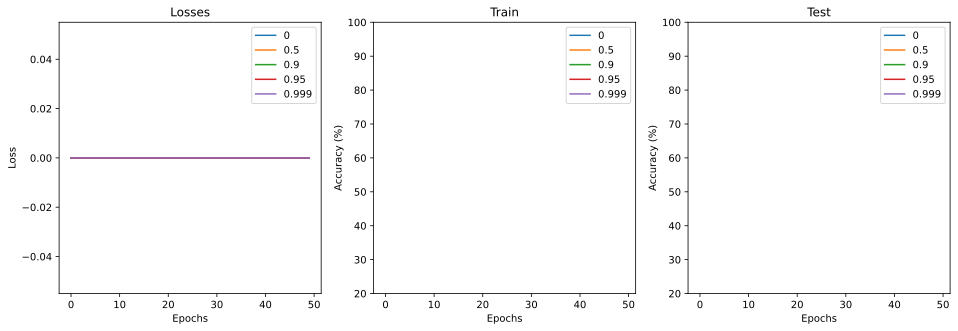

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(16,5))

for i in range(3):
  ax[i].plot(results[:,:,i])
  ax[i].legend(momenta)
  ax[i].set_xlabel('Epochs')
  if i==0:
    ax[i].set_ylabel('Loss')
  else:
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([20,100])

ax[0].set_title('Losses')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()